In [1]:
#@title Self-guidance modules
from collections import defaultdict
from diffusers import DiffusionPipeline
import torch
from typing import Any, Callable, Dict, List, Optional, Tuple, Union
import diffusers
import torch.nn.functional as F
import torchvision.transforms.functional as TF
import numpy as np

import math
from diffusers import StableDiffusionXLPipeline
from diffusers.pipelines.stable_diffusion_xl import StableDiffusionXLPipelineOutput

from utils import concat_images, search_sequence_numpy
from edits import centroid, normalized_attention, appearance_difference, silhouette_difference


class SelfGuidanceEdits:
  @staticmethod
  def shape(attn, i, tgt, thresh=True, idxs=None, L2=False):
    attn = attn[i]
    tgt_attn = tgt[i].to(attn.device) if tgt is not None else None

    if idxs is not None:
      attn = attn[...,idxs]
      tgt_attn = tgt_attn[...,idxs]
    shape_obs = normalized_attention(attn)
    shape_tgt = normalized_attention(tgt_attn)
    
    if L2: return (0.5*(shape_obs - shape_tgt)**2).mean()
    return (shape_obs-shape_tgt).abs().mean()

  @staticmethod
  def change_centroid(attn, i, tgt=None, shift=(0., 0.), relative=False, idxs=None, L2=False):
    attn = attn[i]
    tgt_attn = tgt[i].to(attn.device) if tgt is not None else None

    if relative: assert tgt_attn is not None
    tgt_attn = tgt_attn if tgt_attn is not None else attn
    if idxs is not None:
      attn = attn[...,idxs]
      tgt_attn = tgt_attn[...,idxs]
    shift = torch.tensor(shift).to(attn.device)

    obs_centroid = centroid(attn)
    tgt_centroid = shift.reshape((1,) * (obs_centroid.ndim - shift.ndim) + shift.shape)
    if relative: tgt_centroid = centroid(tgt_attn) + tgt_centroid
    if L2: return (0.5*(obs_centroid - tgt_centroid)**2).mean()
    return (obs_centroid-tgt_centroid).abs().mean()

  @staticmethod
  def size(attn, i, tgt=None, relative=False, shift=(0.,), thresh=True, idxs=None, L2=False):
    attn = attn[i]
    tgt_attn = tgt[i].to(attn.device) if tgt is not None else None

    if relative: assert tgt_attn is not None
    tgt_attn = tgt_attn if tgt_attn is not None else attn
    if idxs is not None:
      attn = attn[...,idxs]
      tgt_attn = tgt_attn[...,idxs]
    shift = torch.tensor(shift).to(attn.device)
    if thresh:
      def _size(report_attn):
        attn_norm = normalized_attention(report_attn)
        return attn_norm.mean((-2, -3))[..., None]
    else:
      def _size(attn):
        return attn.mean((-2, -3))[..., None]

    size_obs = _size(attn)
    size_tgt = shift.reshape((1,) * (size_obs.ndim - shift.ndim) + shift.shape)
    if relative: size_tgt = _size(tgt_attn) + size_tgt
    if L2: return (0.5*(size_obs - size_tgt)**2).mean()
    return (size_obs-size_tgt).abs().mean()

class SelfGuidanceSDXLPipeline(StableDiffusionXLPipeline):
    def get_sg_aux(self, cfg=True, transpose=True):
      aux = defaultdict(dict)
      for name, aux_module in self.unet.named_modules():
        try:
          module_aux = aux_module._aux
          if transpose:
            for k, v in module_aux.items():
              if cfg: v = torch.utils._pytree.tree_map(lambda vv: vv.chunk(2)[1] if vv is not None else None, v)
              aux[k][name] = v
          else:
            aux[name] = module_aux
            if cfg:
              aux[name] = {k: torch.utils._pytree.tree_map(lambda vv: vv.chunk(2)[1] if vv is not None else None, v) for k, v in aux[name].items()}
        except AttributeError: pass
      return aux

    def wipe_sg_aux(self):
      for name, aux_module in self.unet.named_modules():
        try: del aux_module._aux
        except AttributeError: pass

    @torch.no_grad()
    def __call__(
        self,
        prompt: Union[str, List[str]] = None,
        prompt_2: Optional[Union[str, List[str]]] = None,
        height: Optional[int] = None,
        width: Optional[int] = None,
        num_inference_steps: int = 50,
        denoising_end: Optional[float] = None,
        guidance_scale: float = 5.0,
        negative_prompt: Optional[Union[str, List[str]]] = None,
        negative_prompt_2: Optional[Union[str, List[str]]] = None,
        num_images_per_prompt: Optional[int] = 1,
        eta: float = 0.0,
        generator: Optional[Union[torch.Generator, List[torch.Generator]]] = None,
        latents: Optional[torch.FloatTensor] = None,
        prompt_embeds: Optional[torch.FloatTensor] = None,
        negative_prompt_embeds: Optional[torch.FloatTensor] = None,
        pooled_prompt_embeds: Optional[torch.FloatTensor] = None,
        negative_pooled_prompt_embeds: Optional[torch.FloatTensor] = None,
        output_type: Optional[str] = "pil",
        return_dict: bool = True,
        callback: Optional[Callable[[int, int, torch.FloatTensor], None]] = None,
        callback_steps: int = 1,
        cross_attention_kwargs: Optional[Dict[str, Any]] = None,
        guidance_rescale: float = 0.0,
        original_size: Optional[Tuple[int, int]] = None,
        crops_coords_top_left: Tuple[int, int] = (0, 0),
        target_size: Optional[Tuple[int, int]] = None,
        sg_grad_wt = 1.0,
        sg_edits = None,
        sg_loss_rescale = 1000.0, #prevent fp16 underflow
        debug=False,
        sg_t_start=0,
        sg_t_end=-1,
    ):
        # 0. Default height and width to unet
        height = height or self.default_sample_size * self.vae_scale_factor
        width = width or self.default_sample_size * self.vae_scale_factor

        original_size = original_size or (height, width)
        target_size = target_size or (height, width)

        # 1. Check inputs. Raise error if not correct
        self.check_inputs(
            prompt,
            prompt_2,
            height,
            width,
            callback_steps,
            negative_prompt,
            negative_prompt_2,
            prompt_embeds,
            negative_prompt_embeds,
            pooled_prompt_embeds,
            negative_pooled_prompt_embeds,
        )

        # 2. Define call parameters
        if prompt is not None and isinstance(prompt, str):
            batch_size = 1
        elif prompt is not None and isinstance(prompt, list):
            batch_size = len(prompt)
        else:
            batch_size = prompt_embeds.shape[0]

        device = self._execution_device

        # here `guidance_scale` is defined analog to the guidance weight `w` of equation (2)
        # of the Imagen paper: https://arxiv.org/pdf/2205.11487.pdf . `guidance_scale = 1`
        # corresponds to doing no classifier free guidance.
        do_classifier_free_guidance = guidance_scale > 1.0
        do_self_guidance = sg_grad_wt > 0 and sg_edits is not None

        if do_self_guidance:
          prompt_text_ids = self.tokenizer(prompt, return_tensors='np')['input_ids'][0]
          for edit_key, edits in sg_edits.items():
            for edit in edits:
              if 'words' not in edit:
                edit['idxs'] = np.arange(len(prompt_text_ids))
              else:
                words = edit['words']
                if not isinstance(words, list): words = [words]
                idxs = []
                for word in words:
                  word_ids = self.tokenizer(word, return_tensors='np')['input_ids']
                  word_ids = word_ids[word_ids < 49406]
                  idxs.append(search_sequence_numpy(prompt_text_ids, word_ids))
                edit['idxs'] = np.concatenate(idxs)

        # 3. Encode input prompt
        text_encoder_lora_scale = (
            cross_attention_kwargs.get("scale", None) if cross_attention_kwargs is not None else None
        )
        (
            prompt_embeds,
            negative_prompt_embeds,
            pooled_prompt_embeds,
            negative_pooled_prompt_embeds,
        ) = self.encode_prompt(
            prompt=prompt,
            prompt_2=prompt_2,
            device=device,
            num_images_per_prompt=num_images_per_prompt,
            do_classifier_free_guidance=do_classifier_free_guidance,
            negative_prompt=negative_prompt,
            negative_prompt_2=negative_prompt_2,
            prompt_embeds=prompt_embeds,
            negative_prompt_embeds=negative_prompt_embeds,
            pooled_prompt_embeds=pooled_prompt_embeds,
            negative_pooled_prompt_embeds=negative_pooled_prompt_embeds,
            lora_scale=text_encoder_lora_scale,
        )

        # 4. Prepare timesteps
        self.scheduler.set_timesteps(num_inference_steps, device=device)

        timesteps = self.scheduler.timesteps
        print(prompt_embeds.dtype)
        # 5. Prepare latent variables
        num_channels_latents = self.unet.config.in_channels
        latents = self.prepare_latents(
            batch_size * num_images_per_prompt,
            num_channels_latents,
            height,
            width,
            prompt_embeds.dtype,
            device,
            generator,
            latents,
        )

        # 6. Prepare extra step kwargs. TODO: Logic should ideally just be moved out of the pipeline
        extra_step_kwargs = self.prepare_extra_step_kwargs(generator, eta)

        # 7. Prepare added time ids & embeddings
        add_text_embeds = pooled_prompt_embeds
        add_time_ids = self._get_add_time_ids(
            original_size, crops_coords_top_left, target_size, dtype=prompt_embeds.dtype
        )

        if do_classifier_free_guidance:
            prompt_embeds = torch.cat([negative_prompt_embeds, prompt_embeds], dim=0)
            add_text_embeds = torch.cat([negative_pooled_prompt_embeds, add_text_embeds], dim=0)
            add_time_ids = torch.cat([add_time_ids, add_time_ids], dim=0)

        prompt_embeds = prompt_embeds.to(device)
        add_text_embeds = add_text_embeds.to(device)
        add_time_ids = add_time_ids.to(device).repeat(batch_size * num_images_per_prompt, 1)

        # 8. Denoising loop
        num_warmup_steps = max(len(timesteps) - num_inference_steps * self.scheduler.order, 0)

        # 7.1 Apply denoising_end
        if denoising_end is not None and type(denoising_end) == float and denoising_end > 0 and denoising_end < 1:
            discrete_timestep_cutoff = int(
                round(
                    self.scheduler.config.num_train_timesteps
                    - (denoising_end * self.scheduler.config.num_train_timesteps)
                )
            )
            num_inference_steps = len(list(filter(lambda ts: ts >= discrete_timestep_cutoff, timesteps)))
            timesteps = timesteps[:num_inference_steps]

        self.wipe_sg_aux()
        torch.cuda.empty_cache()
        if sg_t_end < 0: sg_t_end = len(timesteps)
        with self.progress_bar(total=num_inference_steps) as progress_bar:
            for i, t in enumerate(timesteps):
                # torch.cuda.empty_cache()
                # expand the latents if we are doing classifier free guidance
                with torch.set_grad_enabled(do_self_guidance):#, torch.autograd.detect_anomaly():
                  latents.requires_grad_(do_self_guidance)
                  latent_model_input = torch.cat([latents] * 2) if do_classifier_free_guidance else latents

                  latent_model_input = self.scheduler.scale_model_input(latent_model_input, t)

                  # predict the noise residual
                  added_cond_kwargs = {"text_embeds": add_text_embeds, "time_ids": add_time_ids}
                  noise_pred = self.unet(
                      latent_model_input,
                      t,
                      encoder_hidden_states=prompt_embeds,
                      cross_attention_kwargs=cross_attention_kwargs,
                      added_cond_kwargs=added_cond_kwargs,
                      return_dict=False,
                  )[0]

                  # perform guidance
                  if do_classifier_free_guidance:
                      noise_pred_uncond, noise_pred_text = noise_pred.chunk(2)
                      noise_pred = noise_pred_uncond + guidance_scale * (noise_pred_text - noise_pred_uncond)

                  ### SELF GUIDANCE
                  if do_self_guidance and sg_t_start <= i < sg_t_end:
                    sg_aux = self.get_sg_aux(do_classifier_free_guidance)
                    sg_loss = 0
                    for edit_key, edits in sg_edits.items():
                      if isinstance(edit_key, str): key_aux = sg_aux[edit_key]
                      else: key_aux = {'': {k: sg_aux[k] for k in edit_key}}
                      for edit in edits:
                        wt = edit.get('weight', 1.)
                        if wt:
                          tgt = edit.get('tgt')
                          if tgt is not None:
                            if isinstance(edit_key, str): tgt = tgt[edit_key]
                            else: tgt = {'': {k: tgt[k] for k in edit_key}}
                          edit_loss = torch.stack([edit['fn'](v, i=i, idxs=edit['idxs'], **edit.get('kwargs',{}), tgt=tgt[k] if tgt is not None else None) for k,v in key_aux.items()]).mean()
                          sg_loss += wt * edit_loss
                    sg_grad = torch.autograd.grad(sg_loss_rescale * sg_loss, latents)[0] / sg_loss_rescale
                    if debug: print(f'Self guidance gradient mean magnitude: {sg_grad.abs().mean()}. Pct zeros: {(sg_grad==0).sum()/torch.numel(sg_grad)}')
                    noise_pred = noise_pred + sg_grad_wt * sg_grad
                    assert not noise_pred.isnan().any()
                  latents.detach()
                  ### END SELF GUIDANCE

                if do_classifier_free_guidance and guidance_rescale > 0.0:
                    # Based on 3.4. in https://arxiv.org/pdf/2305.08891.pdf
                    noise_pred = rescale_noise_cfg(noise_pred, noise_pred_text, guidance_rescale=guidance_rescale)

                # compute the previous noisy sample x_t -> x_t-1
                latents = self.scheduler.step(noise_pred, t, latents, **extra_step_kwargs, return_dict=False)[0]

                # call the callback, if provided
                if i == len(timesteps) - 1 or ((i + 1) > num_warmup_steps and (i + 1) % self.scheduler.order == 0):
                    progress_bar.update()
                    if callback is not None and i % callback_steps == 0:
                        callback(i, t, latents)


        torch.cuda.empty_cache()
        if not save_aux: self.wipe_sg_aux()
        latents = latents.detach()
        # make sure the VAE is in float32 mode, as it overflows in float16
        if self.vae.dtype == torch.float16 and self.vae.config.force_upcast:
            self.upcast_vae()
            latents = latents.to(next(iter(self.vae.post_quant_conv.parameters())).dtype)

        if not output_type == "latent":
            image = self.vae.decode(latents / self.vae.config.scaling_factor, return_dict=False)[0]
        else:
            image = latents
            return StableDiffusionXLPipelineOutput(images=image)

        # apply watermark if available
        if self.watermark is not None:
            image = self.watermark.apply_watermark(image)

        image = self.image_processor.postprocess(image, output_type=output_type)

        # Offload last model to CPU
        if hasattr(self, "final_offload_hook") and self.final_offload_hook is not None:
            self.final_offload_hook.offload()

        if not return_dict:
            return (image,)

        return StableDiffusionXLPipelineOutput(images=image)

class SelfGuidanceAttnProcessor:
    r"""
    Default processor for performing attention-related computations.
    """

    def __call__(
        self,
        attn: diffusers.models.attention_processor.Attention,
        hidden_states,
        encoder_hidden_states=None,
        attention_mask=None,
        temb=None,
    ):
        residual = hidden_states

        if attn.spatial_norm is not None:
            hidden_states = attn.spatial_norm(hidden_states, temb)

        input_ndim = hidden_states.ndim

        if input_ndim == 4:
            batch_size, channel, height, width = hidden_states.shape
            hidden_states = hidden_states.view(batch_size, channel, height * width).transpose(1, 2)

        batch_size, sequence_length, _ = (
            hidden_states.shape if encoder_hidden_states is None else encoder_hidden_states.shape
        )
        attention_mask = attn.prepare_attention_mask(attention_mask, sequence_length, batch_size)

        if attn.group_norm is not None:
            hidden_states = attn.group_norm(hidden_states.transpose(1, 2)).transpose(1, 2)

        query = attn.to_q(hidden_states)

        if encoder_hidden_states is None:
            encoder_hidden_states = hidden_states
        elif attn.norm_cross:
            encoder_hidden_states = attn.norm_encoder_hidden_states(encoder_hidden_states)

        key = attn.to_k(encoder_hidden_states)
        value = attn.to_v(encoder_hidden_states)

        query = attn.head_to_batch_dim(query)
        key = attn.head_to_batch_dim(key)
        value = attn.head_to_batch_dim(value)

        attention_probs = attn.get_attention_scores(query, key, attention_mask)

        ### SELF GUIDANCE
        scores_ = attention_probs.reshape(len(query), -1, *attention_probs.shape[1:]).mean(1)
        h=w=math.isqrt(scores_.shape[1])
        scores_ = scores_.reshape(len(scores_), h, w, -1)
        global _SG_RES
        if _SG_RES != scores_.shape[2]:
          scores_ = TF.resize(scores_.permute(0,3,1,2), _SG_RES, antialias=True).permute(0,2,3,1)
        try:
          global save_aux
          if not save_aux:
            len_=len(attn._aux['attn'])
            del attn._aux['attn']
            attn._aux['attn'] = [None]*len_ + [scores_]
          else:
            attn._aux['attn'][-1] = attn._aux['attn'][-1].cpu()
            attn._aux['attn'].append(scores_)
        except:
          del attn._aux['attn']
          attn._aux = {'attn': [scores_]}
        ### END SELF GUIDANCE

        hidden_states = torch.bmm(attention_probs, value)
        hidden_states = attn.batch_to_head_dim(hidden_states)

        # linear proj
        hidden_states = attn.to_out[0](hidden_states)
        # dropout
        hidden_states = attn.to_out[1](hidden_states)

        if input_ndim == 4:
            hidden_states = hidden_states.transpose(-1, -2).reshape(batch_size, channel, height, width)

        if attn.residual_connection:
            hidden_states = hidden_states + residual

        hidden_states = hidden_states / attn.rescale_output_factor

        return hidden_states

class SelfGuidanceAttnProcessor2_0:
    r"""
    Processor for implementing scaled dot-product attention (enabled by default if you're using PyTorch 2.0).
    """

    def __init__(self):
        if not hasattr(F, "scaled_dot_product_attention"):
            raise ImportError("AttnProcessor2_0 requires PyTorch 2.0, to use it, please upgrade PyTorch to 2.0.")

    def __call__(
        self,
        attn: diffusers.models.attention_processor.Attention,
        hidden_states,
        encoder_hidden_states=None,
        attention_mask=None,
        temb=None,
    ):
        residual = hidden_states

        if attn.spatial_norm is not None:
            hidden_states = attn.spatial_norm(hidden_states, temb)

        input_ndim = hidden_states.ndim

        if input_ndim == 4:
            batch_size, channel, height, width = hidden_states.shape
            hidden_states = hidden_states.view(batch_size, channel, height * width).transpose(1, 2)

        batch_size, sequence_length, _ = (
            hidden_states.shape if encoder_hidden_states is None else encoder_hidden_states.shape
        )

        if attention_mask is not None:
            attention_mask = attn.prepare_attention_mask(attention_mask, sequence_length, batch_size)
            # scaled_dot_product_attention expects attention_mask shape to be
            # (batch, heads, source_length, target_length)
            attention_mask = attention_mask.view(batch_size, attn.heads, -1, attention_mask.shape[-1])

        if attn.group_norm is not None:
            hidden_states = attn.group_norm(hidden_states.transpose(1, 2)).transpose(1, 2)

        query = attn.to_q(hidden_states)

        if encoder_hidden_states is None:
            encoder_hidden_states = hidden_states
        elif attn.norm_cross:
            encoder_hidden_states = attn.norm_encoder_hidden_states(encoder_hidden_states)

        key = attn.to_k(encoder_hidden_states)
        value = attn.to_v(encoder_hidden_states)

        ### SELF GUIDANCE
        query_ = attn.head_to_batch_dim(query)
        key_ = attn.head_to_batch_dim(key)
        scores_ = attn.get_attention_scores(query_, key_, attention_mask)
        scores_ = scores_.reshape(len(query), -1, *scores_.shape[1:]).mean(1)
        h=w=math.isqrt(scores_.shape[1])
        scores_ = scores_.reshape(len(scores_), h, w, -1)
        global _SG_RES
        if _SG_RES != scores_.shape[2]:
          scores_ = TF.resize(scores_.permute(0,3,1,2), _SG_RES, antialias=True).permute(0,2,3,1)
        try:
          global save_aux
          if not save_aux:
            len_=len(attn._aux['attn'])
            del attn._aux['attn']
            attn._aux['attn'] = [None]*len_ + [scores_]
          else:
            attn._aux['attn'][-1] = attn._aux['attn'][-1].cpu()
            attn._aux['attn'].append(scores_)
        except:
          try: del attn._aux['attn']
          except: pass
          attn._aux = {'attn': [scores_]}
        ### END SELF GUIDANCE

        inner_dim = key.shape[-1]
        head_dim = inner_dim // attn.heads

        query = query.view(batch_size, -1, attn.heads, head_dim).transpose(1, 2)

        key = key.view(batch_size, -1, attn.heads, head_dim).transpose(1, 2)

        value = value.view(batch_size, -1, attn.heads, head_dim).transpose(1, 2)

        # the output of sdp = (batch, num_heads, seq_len, head_dim)
        # TODO: add support for attn.scale when we move to Torch 2.1
        hidden_states = F.scaled_dot_product_attention(
            query, key, value, attn_mask=attention_mask, dropout_p=0.0, is_causal=False
        )

        hidden_states = hidden_states.transpose(1, 2).reshape(batch_size, -1, attn.heads * head_dim)
        hidden_states = hidden_states.to(query.dtype)

        # linear proj
        hidden_states = attn.to_out[0](hidden_states)
        # dropout
        hidden_states = attn.to_out[1](hidden_states)

        if input_ndim == 4:
            hidden_states = hidden_states.transpose(-1, -2).reshape(batch_size, channel, height, width)

        if attn.residual_connection:
            hidden_states = hidden_states + residual

        hidden_states = hidden_states / attn.rescale_output_factor

        return hidden_states

/home/andrey/anaconda3/envs/ml_project/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
#@title Initialize pipeline { form-width: "20%"}
use_ddpm = True # @param {type:"boolean"}

from functools import partial

base = SelfGuidanceSDXLPipeline.from_pretrained(
    "stabilityai/stable-diffusion-xl-base-1.0",  use_safetensors=True, torch_dtype=torch.float16, variant="fp16", use_onnx=False
)
base.to("cuda:0")

attn_greenlist = ["up_blocks.0.attentions.1.transformer_blocks.1.attn2",
                  "up_blocks.0.attentions.1.transformer_blocks.2.attn2",
                  "up_blocks.0.attentions.1.transformer_blocks.3.attn2"]
# attn_greenlist = None

for name, block in base.unet.named_modules():
  if isinstance(block, (diffusers.models.unet_2d_blocks.CrossAttnDownBlock2D, diffusers.models.unet_2d_blocks.CrossAttnUpBlock2D, diffusers.models.unet_2d_blocks.UNetMidBlock2DCrossAttn)):
    for attn_name, attn in block.named_modules():
      full_name = name+'.'+attn_name
      if 'attn2' not in attn_name or (attn_greenlist and full_name not in attn_greenlist): continue
      if isinstance(attn, diffusers.models.attention_processor.Attention):
        if isinstance(attn.processor, diffusers.models.attention_processor.AttnProcessor2_0):
          attn.processor = SelfGuidanceAttnProcessor2_0()
        elif isinstance(attn.processor, diffusers.models.attention_processor.AttnProcessor):
          attn.processor = SelfGuidanceAttnProcessor()
        else:
          raise NotImplementedError("Self-guidance is not implemented for this attention processor")

if use_ddpm:
  print('Using DDPM as scheduler.')
  base.scheduler = diffusers.DDPMScheduler.from_config(base.scheduler.config)
def resave_aux_key(module, *args, old_key="attn", new_key="last_attn"):
  module._aux[new_key] = module._aux[old_key]
_SG_RES = 64
def resize(x):
  return TF.resize(x, _SG_RES, antialias=True)
def stash_to_aux(module, args, kwargs, output, mode, key="last_feats", args_idx=None, kwargs_key=None, fn_to_run=None):
  to_save = None
  if mode == "args":
    to_save = input
    if args_idx is not None: to_save = args[args_idx]
  elif mode == "kwargs":
    assert kwargs_key is not None
    to_save = kwargs[kwargs_key]
  elif mode == "output":
    to_save = output
  if fn_to_run is not None: to_save = fn_to_run(to_save)
  try:
    global save_aux
    if not save_aux:
      len_ = len(module._aux[key])
      del module._aux[key]
      module._aux[key] = [None]*len_ + [to_save]
    else:
      module._aux[key][-1] = module._aux[key][-1].cpu()
      module._aux[key].append(to_save)
  except:
    try: del module._aux[key]
    except: pass
    module._aux = {key: [to_save]}
# base.unet.up_blocks[2].register_forward_hook(partial(stash_to_aux,mode="kwargs", kwargs_key="hidden_states"), with_kwargs=True)
base.unet.up_blocks[2].register_forward_hook(partial(stash_to_aux,mode="output"), with_kwargs=True)
# base.unet.up_blocks[1].resnets[1].conv2.register_forward_hook(partial(stash_to_aux,mode="args", args_idx=0), with_kwargs=True)
base.unet.up_blocks[0].attentions[1].transformer_blocks[3].attn2.register_forward_hook(resave_aux_key)
# clear_output()

Loading pipeline components...: 100%|██████████| 7/7 [00:01<00:00,  6.15it/s]


Using DDPM as scheduler.


In [3]:
prompt="a photo of a kangaroo and a punching bag at the gym" 
if prompt is not None and isinstance(prompt, str):
    batch_size = 1
elif prompt is not None and isinstance(prompt, list):
    batch_size = len(prompt)
else:
    batch_size = prompt_embeds.shape[0]
num_images_per_prompt = 1
num_channels_latents = base.unet.config.in_channels
height = base.default_sample_size * base.vae_scale_factor
width = base.default_sample_size * base.vae_scale_factor

In [4]:
import torch
torch.manual_seed(0)
import random
random.seed(0)
import numpy as np
np.random.seed(0)

In [5]:
latents = base.prepare_latents(batch_size * num_images_per_prompt, num_channels_latents, height, width, torch.float16, "cuda:0", generator=None, latents=None)

torch.float16


100%|██████████| 300/300 [00:39<00:00,  7.53it/s]


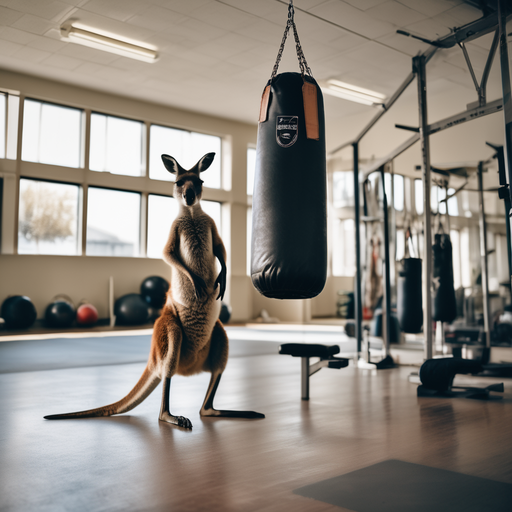

In [6]:
#@title Generate (for editing generated image below)
save_aux=True # @param {type:"boolean"}
n_img=1  # @param {type:"integer"}
out = base(prompt=[prompt]*n_img, num_inference_steps=300, latents=latents).images
if save_aux: 
    aux = base.get_sg_aux()
concat_images(out)

In [ ]:
#@title Generate with self-guidance
save_aux=False
aux_idx=0
n_img=1 # @param {type:"integer"}
processed_aux = {k:torch.utils._pytree.tree_map(lambda x: x[aux_idx:aux_idx+1].repeat_interleave(n_img, 0).cpu(), v) for k,v in aux.items()}
try: processed_aux = {k:torch.utils._pytree.tree_map(lambda x: x[aux_idx:aux_idx+1].repeat_interleave(n_img, 0).cpu(), v) for k,v in aux.items()}
except: pass
sg_edits = {
    ('last_attn', 'last_feats'): [{
        'words': ['photo', 'punching bag', 'gym'],
         'fn': appearance_difference,
         'weight': 0.25,
         'tgt': processed_aux,
         'threshold': 0.75,
         'kwargs': {}
     }, 
    ],
    'attn': [
        {
        'words': ['photo', 'gym', 'punching bag'],
         'fn': silhouette_difference,
         'kwargs': {
                 # 'dx': -0.5
                 # 'sx': 1.5,
                 # 'sy': 1.5
             },
          'weight': 1.5,
          'tgt': processed_aux
        },
         #{
         #    'words': ['punching bag'],
         #    'fn': SelfGuidanceEdits.size,
         #    'kwargs': {
         #      'shift': (1.0,),
         #    },
         #  'weight': 2.0,
        #},
        {
              'words': ['kangaroo'],
              'fn': SelfGuidanceEdits.change_centroid,
              'kwargs': {
               'shift': (.9, .9),
               'relative': False
             },
             'weight': 6.,
             # 'tgt': processed_aux
         },
    ]
}

# How many sampling steps to take
num_inference_steps = 300 # @param {type:"integer"}
# To avoid numerical underflow, scale loss by this amount and then divide gradients after backprop
sg_loss_rescale = 1000. # @param {type: "number"}
# Weight on self guidance term in sampling
sg_grad_wt = 1000. # @param {type: "number"}
# Step # to start self guidance.
sg_t_start = 20 # @param {type:"integer"}
# Step # to end self guidance.
sg_t_end = 280 # @param {type:"integer"}
out = base(prompt=[prompt]*n_img, sg_grad_wt=sg_grad_wt, sg_edits=sg_edits, num_inference_steps=num_inference_steps, sg_loss_rescale=sg_loss_rescale, debug=False, sg_t_start=sg_t_start, sg_t_end=sg_t_end, latents=latents).images
concat_images(out)

torch.float16


 54%|█████▍    | 162/300 [01:34<01:29,  1.55it/s]

In [9]:
processed_aux.keys()

dict_keys(['attn', 'last_attn', 'last_feats'])

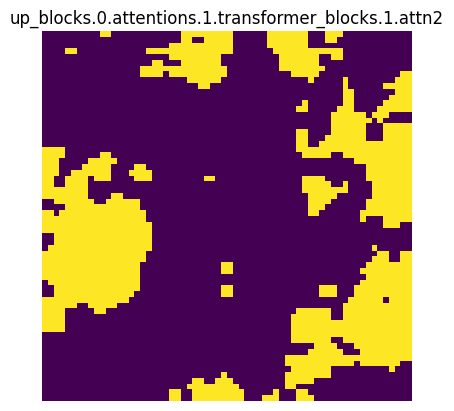

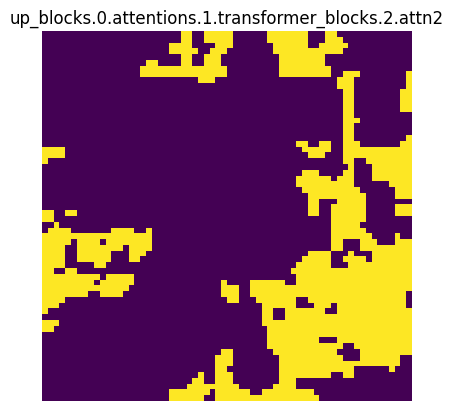

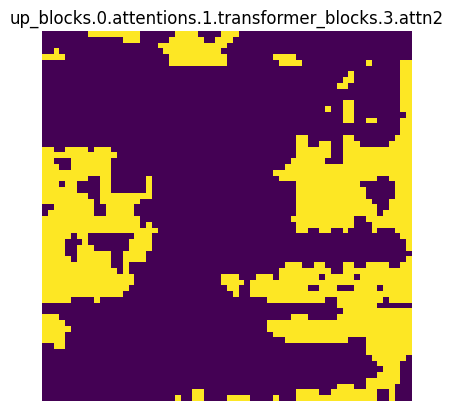

In [11]:
#@title Visualize attention (must check save_aux)
from matplotlib import pyplot as plt
prompt_text_ids = base.tokenizer(prompt, return_tensors='np')['input_ids'][0]
attn_words = 'gym'
word_ids = base.tokenizer(attn_words, return_tensors='np')['input_ids']
word_ids = word_ids[word_ids < 49406]
idxs = search_sequence_numpy(prompt_text_ids, word_ids)
# for k,v in {k:(torch.stack([_.cpu() for _ in v])[:].mean(0)[0][..., idxs].mean(-1)[None, ..., None])[0][...,0] for k,v in aux['attn'].items() if k.startswith('up')}.items():
for k,v in {k:normalized_attention(torch.stack([_.cpu() for _ in v])[:].mean(0)[0][..., idxs].mean(-1)[None, ..., None],hard=True,threshold=0.8)[0][...,0] for k,v in aux['attn'].items() if k.startswith('up')}.items():
  plt.figure()
  plt.title(k)
  plt.axis('off')
  plt.imshow(v)
  # break